In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mass import MassSpectrum
from mass import VanKrevelen

/Users/av/Desktop/masslib/mass.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import inset_axes as inset_axes_func


In [2]:
def vank(result, name):
    fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
    vk = VanKrevelen(result.table)

    vk.table['volume'] = vk.table['I'] / vk.table['I'].median()
    
    vk.table['color'] = 'blue'
    vk.table.loc[(vk.table['C'] > 0) & (vk.table['H'] > 0) &(vk.table['O'] > 0) & (vk.table['N'] > 0) & (vk.table['S'] < 1), 'color'] = 'orange'
    vk.table.loc[(vk.table['C'] > 0) & (vk.table['H'] > 0) &(vk.table['O'] > 0) & (vk.table['N'] < 1) & (vk.table['S'] > 0), 'color'] = 'green'
    vk.table.loc[(vk.table['C'] > 0) & (vk.table['H'] > 0) &(vk.table['O'] > 0) & (vk.table['N'] > 0) & (vk.table['S'] > 0), 'color'] = 'red'
    
    vk.draw_scatter(ax, alpha=0.3, c=vk.table['color'], s=vk.table['volume'])
    
    ax.text(0.05, 0.1, 'CHO', c='blue', size=8)
    ax.text(0.2, 0.1, 'CHON', c='orange', size=8)
    ax.text(0.35, 0.1, 'CHOS', c='green', size=8)
    ax.text(0.5, 0.1, 'CHONS', c='red', size=8)

    num_formules = result.table['assign'].sum()
    ax.set_title(f'{num_formules} formules\n{name}', size=10)
    name = name.replace('\n', ' ')
    fig.tight_layout()
    #plt.savefig(f'dataout/{name}_vk.svg')

In [3]:
def specplot(result, name):
    fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

    x = result.table['mass'].to_list()
    y = result.table['I'].to_list()

    for i in range(0, len(x), 1):
        a = (x[i], x[i])
        b = (0, y[i])
        ax.plot(a, b, color='b', linewidth=0.5)
    
    ax.set_title(f'{len(x)} formules\n{name}', size=10)
    ax.set_xlabel('m/z, Da')
    ax.set_ylabel('Intensity')
    ax.set_xlim(0)
    ax.set_ylim(0)

    name = name.replace('\n', ' ')
    fig.tight_layout()
    #plt.savefig(f'dataout/{name}_spec.svg')

In [4]:
def load(file, #filename
        mass, #name of mass column
        intens, #name of intensity column
        separ = '\t', #table separator
        tol=100, #intensivity treshold
        ): 
    
    #load data, remove all except mass and intesivity
    data = pd.read_csv(file, sep=separ)
    data = data.loc[:, [mass, intens]]
    data.columns = ['mass', 'I']
    #take data above intesivity treshold
    data = data.loc[data['I'] > tol].reset_index()
    #take name from filename
    name = file.split('/')[-1].split('.')[0]
    #make massspec sample
    spec = MassSpectrum(table=data)
    #plot masspec
    specplot(spec, name)
    return spec

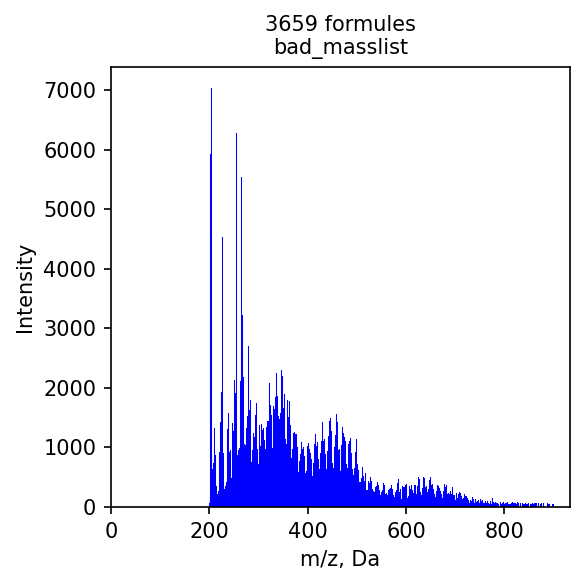

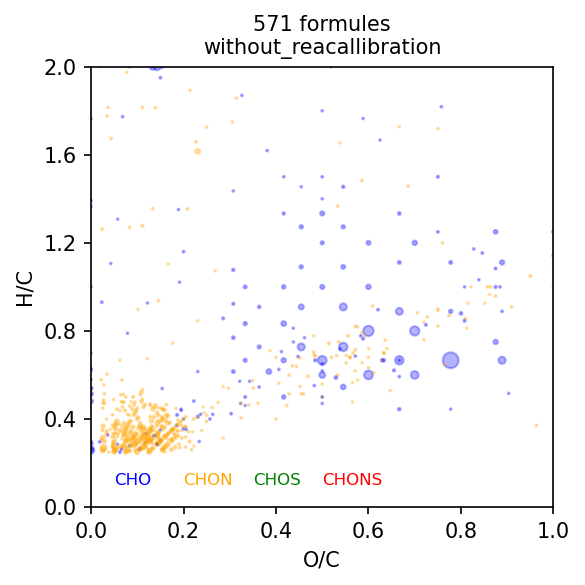

In [7]:
bad_spec = load(file="data/bad_masslist.txt", 
                    mass='m/z', 
                    intens='Intensity', 
                    separ='\t', 
                    tol=50)

spec = bad_spec.assign_dummy(elems='CHON', rel_error=0.5)
vank(spec, 'without_reacallibration')

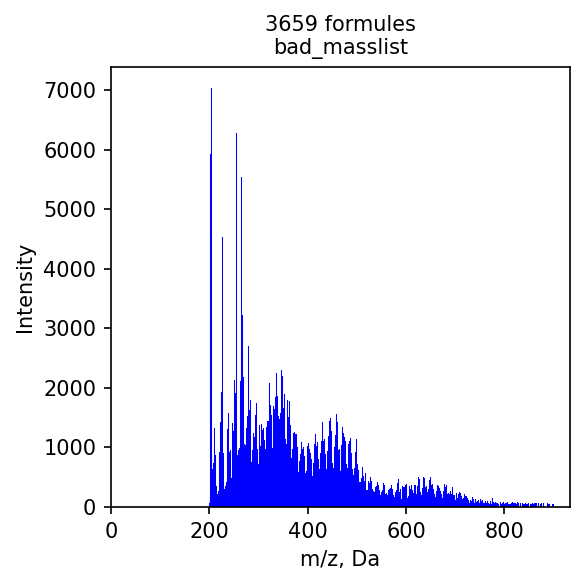

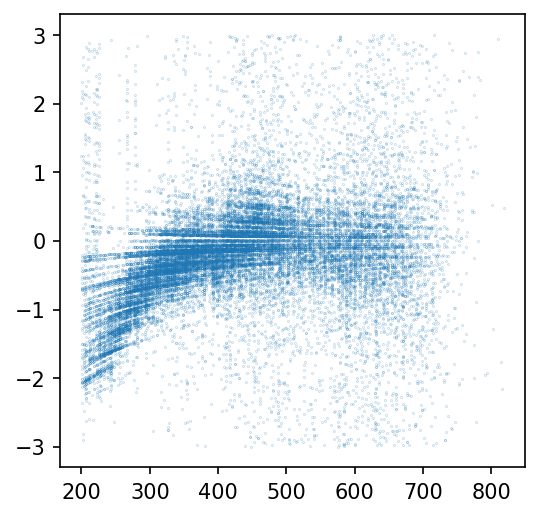

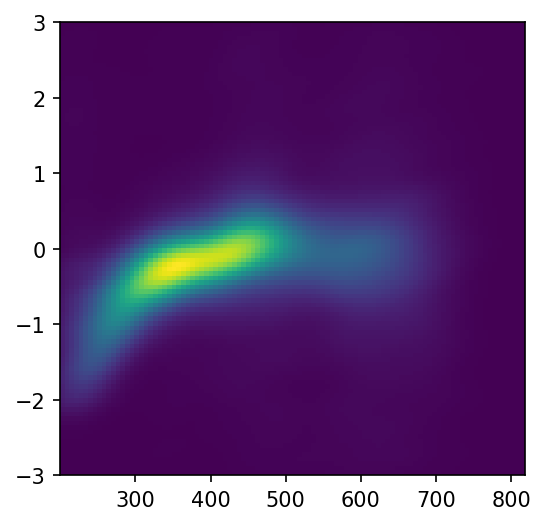

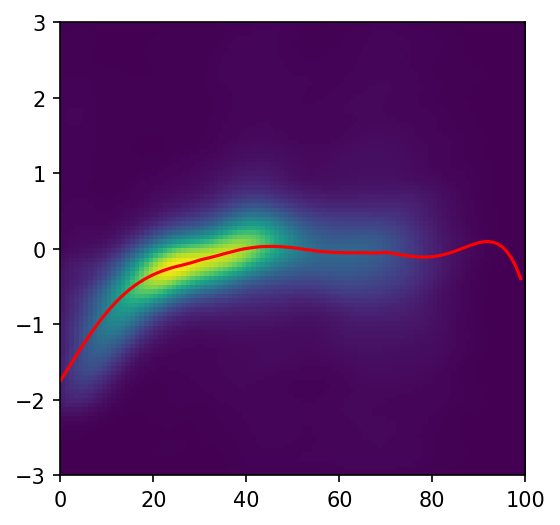

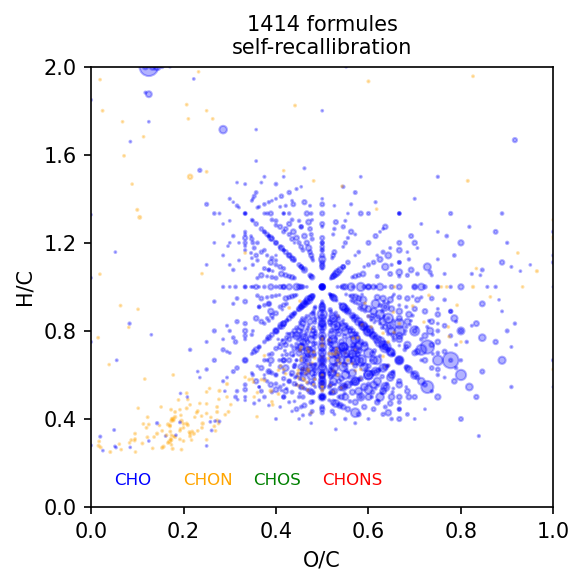

In [8]:
bad_spec = load(file="data/bad_masslist.txt", 
                    mass='m/z', 
                    intens='Intensity', 
                    separ='\t', 
                    tol=50)

self_recal = bad_spec.self_recallibrate()
spec = self_recal.assign_dummy(elems='CHON', rel_error=0.5)
vank(spec, 'self-recallibration')

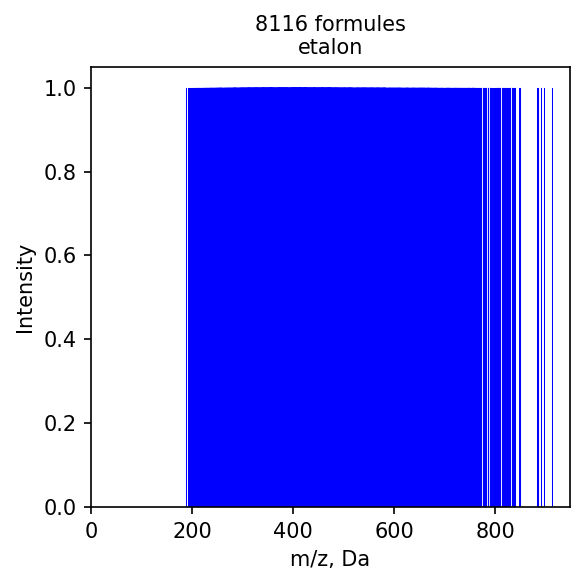

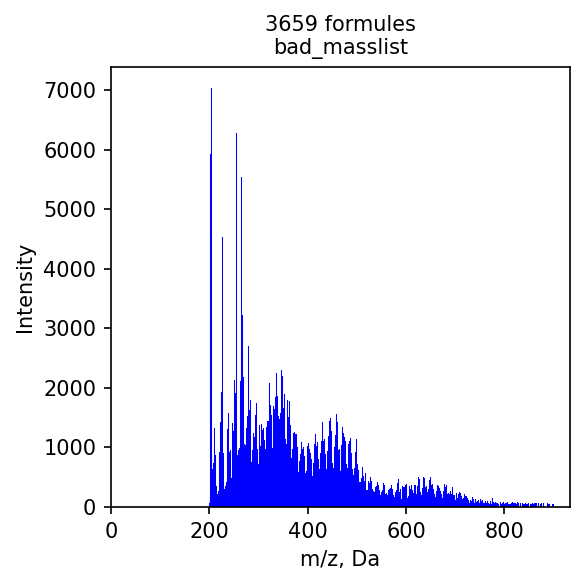

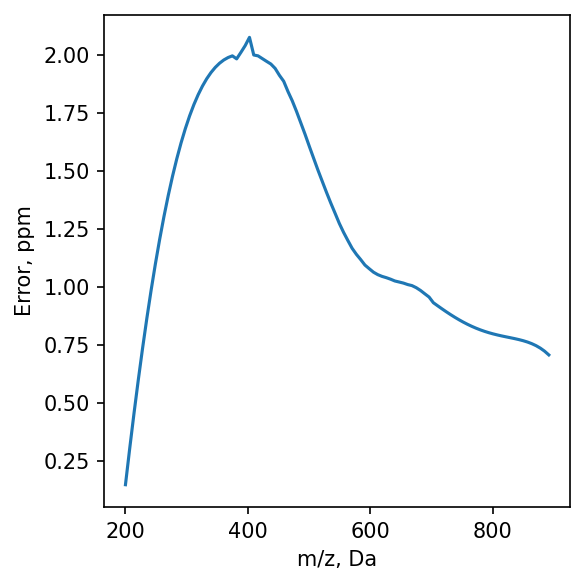

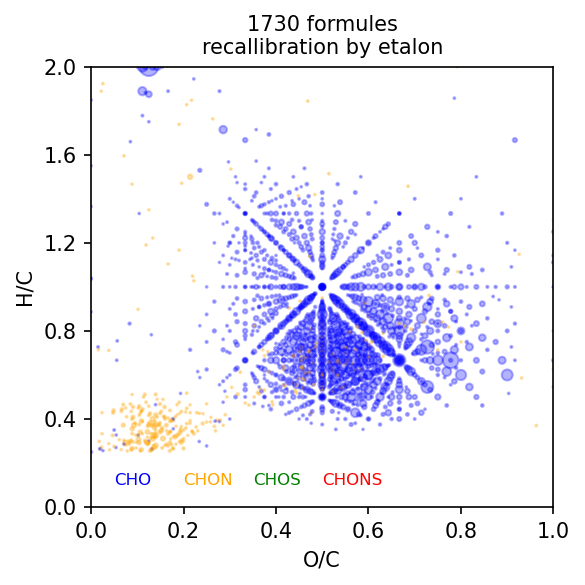

In [9]:
etalon = load(file="data/etalon.csv", 
                    mass='m/z', 
                    intens='I', 
                    separ=',', 
                    tol=0)

bad_spec = load(file="data/bad_masslist.txt", 
                    mass='m/z', 
                    intens='Intensity', 
                    separ='\t', 
                    tol=50)

recal_by_etalon = bad_spec.recallibrate_by_etalon(etalon)
spec = recal_by_etalon.assign_dummy(elems='CHON', rel_error=0.5)
vank(spec, 'recallibration by etalon')